In [1]:

import os
import torch
import torchvision
from torch.utils.data import  DataLoader
from newdataset import UntrimmedDataset
from model import CPD_SSL
data_root = os.path.join(os.getcwd(), 'Untrimmed_accline')
n_fft = 32
hop_length = int(n_fft/2)
device = 'cpu'
feature_size = 32

squeeze_net = torchvision.models.squeezenet1_1(progress=True).to(device)
squeeze_net.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=(1,1)),
    torch.nn.Flatten(),
    torch.nn.Linear(512, feature_size, bias=True))
backbone =  squeeze_net

dataset = UntrimmedDataset(root_dir=data_root,
                               kernel_size=1024,
                               stride=256,
                               device='cpu',
                               n_fft=n_fft,
                               hop_length=hop_length)
    
dataloader = DataLoader(dataset, batch_size=4)

cpd = CPD_SSL(backbone='SqeezeNet', feature_size=32, device='cpu')
cpd.train(dataloader, epoch=200)

/Users/lilmae/Desktop/CarVibration/newdataset.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stft = torch.stft(input=torch.tensor(x_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_stft = torch.stft(input=torch.tensor(y_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_stft = torch.stft(inp

RuntimeError: Input type (c10::complex<double>) and bias type (float) should be the same

/Users/lilmae/Desktop/CarVibration/newdataset.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stft = torch.stft(input=torch.tensor(x_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_stft = torch.stft(input=torch.tensor(y_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_stft = torch.stft(inp

77
torch.Size([3, 17, 65])


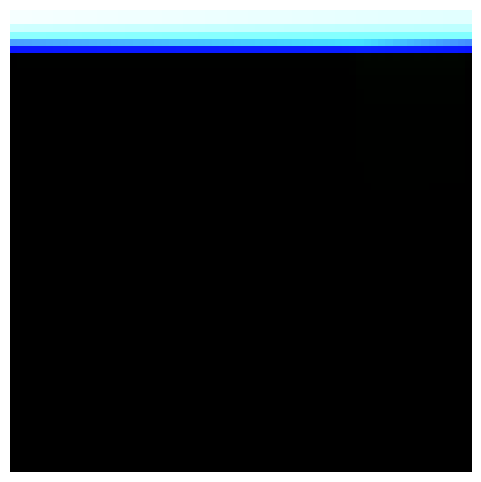

In [31]:
import matplotlib.pyplot as plt
print(len(dataset))

for stft, class_info, is_new in dataloader:
    a_stft = stft[2]
    # print(a_stft)
    break
print(a_stft.shape)

new_stft = []
for ch in a_stft:
    new_stft.append(torch.abs(ch))
new_stft = torch.stack(new_stft)



from torchvision import transforms, utils
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기를 256x256으로 조정
])

new_stft = transform(new_stft)

tensor_rgb = new_stft.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(tensor_rgb)
plt.axis('off')
plt.show()

In [23]:
from torchvision import transforms, utils

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기를 256x256으로 조정
    transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 반전
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])
def sampler(batch):
    query = batch[:-1]
    positive_pair = batch[1:]
    negative_pair = []

    for i in range(len(batch)-1):
        neg_i = []
        for j in range(len(batch)):
            if i!=j and j!=i+1:
                neg_i.append(batch[j])
        neg_i = torch.stack(neg_i)
        negative_pair.append(neg_i)

    negative_pair = torch.stack(negative_pair)
    
    return query, positive_pair, negative_pair


for stft, class_info, is_new in dataloader:
    stft = transform(stft)
    res = squeeze_net(stft)
    a_res = res[0]
    print(a_res.shape)
    break

/Users/lilmae/Desktop/CarVibration/newdataset.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stft = torch.stft(input=torch.tensor(x_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_stft = torch.stft(input=torch.tensor(y_data),n_fft=self.n_fft,hop_length=self.hop_length,return_complex=True)
/Users/lilmae/Desktop/CarVibration/newdataset.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_stft = torch.stft(inp

TypeError: Input tensor should be a float tensor. Got torch.complex128.

In [33]:
import torch.nn.functional as F


batch = torch.randn([10, 32])

norm_batch = F.normalize(batch, p=2,dim=1)
sim_matrix = torch.mm(norm_batch, norm_batch.t())
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

pos = []
neg = []
for i in range(batch.shape[0]):
    for j in range(batch.shape[0]):
        if j==i+1:
            pos.append(sim_matrix[i][j])
        elif j>i:
            neg.append(sim_matrix[i][j])
pos = torch.stack(pos)
pos_label = torch.ones_like(pos)
neg = torch.stack(neg)
neg_label = torch.zeros_like(neg)

pos_loss = criterion(pos, pos_label)
neg_loss = criterion(neg, neg_label)

print(f'pos_sum : {pos_loss}')
print(f'neg_sum : {neg_loss}')

loss = pos_loss+neg_loss

pos_loss_mean = pos_loss/len(pos)
neg_loss_mean = neg_loss/len(neg)

print(f'loss : {loss} pos_mean : {pos_loss_mean} neg_mean : {neg_loss_mean}')

pos_sum : 6.351304531097412
neg_sum : 25.342113494873047
loss : 31.693418502807617 pos_mean : 0.7057005167007446 neg_mean : 0.7039476037025452


In [ ]:
def nce_loss_fn(history, future, similarity, temperature='0.1'):
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

    N = history.shape[0]
    
    
    sim = similarity(history, future)
    
    
    pos_sim = K.exp(tf.linalg.tensor_diag_part(sim)/temperature)

    tri_mask = np.ones(N ** 2, dtype=np.bool).reshape(N, N)
    tri_mask[np.diag_indices(N)] = False
    neg = tf.reshape(tf.boolean_mask(sim, tri_mask), [N, N - 1])
    all_sim = K.exp(sim/temperature)

    logits = tf.divide(K.sum(pos_sim), K.sum(all_sim, axis=1))

    lbl = np.ones(history.shape[0])
    # categorical cross entropy
    loss = criterion(y_pred = logits, y_true = lbl)
    # loss = K.sum(logits)
    # divide by the size of batch
    #loss = loss / lbl.shape[0]
    # similarity of positive pairs (only for debug)
    mean_sim = K.mean(tf.linalg.tensor_diag_part(sim))
    mean_neg = K.mean(neg)
    return loss, mean_sim, mean_neg

In [ ]:
import torch
import torch.nn.functional as F

# 임의의 10개 텐서 생성 (예시로 각각 128 차원)
tensors = [torch.randn(128) for _ in range(10)]

# 모든 텐서를 하나의 배치로 쌓기
tensor_stack = torch.stack(tensors)

# L2 정규화 (코사인 유사도를 위해 필요)
tensor_norm = F.normalize(tensor_stack, p=2, dim=1)

# 코사인 유사도 계산
cosine_similarities = torch.mm(tensor_norm, tensor_norm.t())

# 유사도 행렬 출력
print(cosine_similarities)

In [ ]:
import torch.nn.functional as F


batch = torch.randn([10, 32])

norm_batch = F.normalize(batch, p=2,dim=1)
sim_matrix = torch.mm(norm_batch, norm_batch.t())
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

pos = []
neg = []
for i in range(batch.shape[0]):
    for j in range(batch.shape[0]):
        if j==i+1:
            pos.append(sim_matrix[i][j])
        elif j>i:
            neg.append(sim_matrix[i][j])
pos = torch.stack(pos)
pos_label = torch.ones_like(pos)
neg = torch.stack(neg)
neg_label = torch.zeros_like(neg)

pos_loss = criterion(pos, pos_label)
neg_loss = criterion(neg, neg_label)

print(f'pos_sum : {pos_loss}')
print(f'neg_sum : {neg_loss}')

loss = pos_loss+neg_loss

pos_loss_mean = pos_loss/len(pos)
neg_loss_mean = neg_loss/len(neg)

print(f'loss : {loss} pos_mean : {pos_loss_mean} neg_mean : {neg_loss_mean}')

In [46]:
temperature = 0.1

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

batch = torch.randn([10, 32])
N= 10

norm_batch = F.normalize(batch, p=2,dim=1)
sim = torch.mm(norm_batch, norm_batch.t())
print(sim)
pos_sim = torch.exp(torch.diag(sim) / temperature)
print(pos_sim)

tri_mask = torch.ones(N, N, dtype=torch.bool)
tri_mask.fill_diagonal_(False)
neg = sim.masked_select(tri_mask).view(N, N - 1)
all_sim = torch.exp(sim / temperature)

logits = torch.sum(pos_sim) / torch.sum(all_sim, dim=1)

lbl = torch.ones(N)
loss = criterion(logits, lbl)

mean_sim = torch.mean(torch.diag(sim))
mean_neg = torch.mean(neg)
print(f'loss : {loss}, mean_sim : {mean_sim}, mean_neg : {mean_neg}')

tensor([[ 1.0000e+00,  2.6138e-01, -4.6458e-02, -2.9407e-01,  1.0684e-01,
         -3.1089e-01, -2.2795e-01, -1.1278e-01, -2.9978e-02,  3.3109e-01],
        [ 2.6138e-01,  1.0000e+00,  1.5032e-03,  1.9884e-01, -2.7683e-01,
         -1.2667e-01,  9.4905e-02,  1.2522e-01, -6.4175e-02,  8.0719e-02],
        [-4.6458e-02,  1.5032e-03,  1.0000e+00,  8.2984e-02,  3.2828e-01,
          2.4155e-02,  2.6219e-01, -8.1057e-03, -7.9073e-04, -1.6928e-01],
        [-2.9407e-01,  1.9884e-01,  8.2984e-02,  1.0000e+00, -2.0992e-01,
          3.3641e-02,  2.6952e-01, -1.1424e-01, -2.1629e-01, -1.9629e-02],
        [ 1.0684e-01, -2.7683e-01,  3.2828e-01, -2.0992e-01,  1.0000e+00,
          1.3096e-01,  2.2677e-02, -3.7913e-01, -1.4136e-02, -2.0485e-01],
        [-3.1089e-01, -1.2667e-01,  2.4155e-02,  3.3641e-02,  1.3096e-01,
          1.0000e+00,  6.1755e-02, -2.1334e-01, -1.3944e-01, -1.4275e-01],
        [-2.2795e-01,  9.4905e-02,  2.6219e-01,  2.6952e-01,  2.2677e-02,
          6.1755e-02,  1.0000e+0

In [47]:
import torch
import torch.nn.functional as F
from torch import nn

__all__ = ['InfoNCE', 'info_nce']


class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.

    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113

    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.

    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.

    Returns:
         Value of the InfoNCE Loss.

     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, temperature=0.1, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode

    def forward(self, query, positive_key, negative_keys=None):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            negative_logits = query @ transpose(negative_keys)

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)


def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]

In [ ]:


temperature = 0.1

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

batch = torch.randn([10, 32])
N= 10

norm_batch = F.normalize(batch, p=2,dim=1)
sim = torch.mm(norm_batch, norm_batch.t())
print(sim)
pos_sim = torch.exp(torch.diag(sim) / temperature)
print(pos_sim)

tri_mask = torch.ones(N, N, dtype=torch.bool)
tri_mask.fill_diagonal_(False)
neg = sim.masked_select(tri_mask).view(N, N - 1)
all_sim = torch.exp(sim / temperature)

logits = torch.sum(pos_sim) / torch.sum(all_sim, dim=1)

lbl = torch.ones(N)
loss = criterion(logits, lbl)

mean_sim = torch.mean(torch.diag(sim))
mean_neg = torch.mean(neg)
print(f'loss : {loss}, mean_sim : {mean_sim}, mean_neg : {mean_neg}')

In [67]:
loss = InfoNCE(negative_mode='paired')
batch = torch.randn([10, 1])

def sampler(batch):
    query = batch[:-1]
    positive_pair = batch[1:]
    negative_pair = []

    for i in range(len(batch)-1):
        neg_i = []
        for j in range(len(batch)):
            if i!=j and j!=i+1:
                neg_i.append(batch[j])
        neg_i = torch.stack(neg_i)
        negative_pair.append(neg_i)

    negative_pair = torch.stack(negative_pair)
    
    return query, positive_pair, negative_pair

res = loss(query, positive_pair, negative_pair)

In [68]:
res

tensor(19.1602)